In [2]:
using Polyhedra, CDDLib, JuMP, PyPlot

In [3]:
m = [-1, 2, -2, 1, 1];
c = [1, -2, 6, -3, -3];
d = [0, 1, 2, 3, 4];
k = 4;

In [4]:
function piecewise(x, breakpts, f)
    @assert(issorted(breakpts))
    #@assert(length(breakpts) == length(f)+1)
    b = searchsortedlast(breakpts, x)
    return f[b](x)
end
fv = [f(x) = m[i]*x+c[i] for i in 1:k];
gr(x) = piecewise(x, d[1:end-1], fv)

gr (generic function with 1 method)

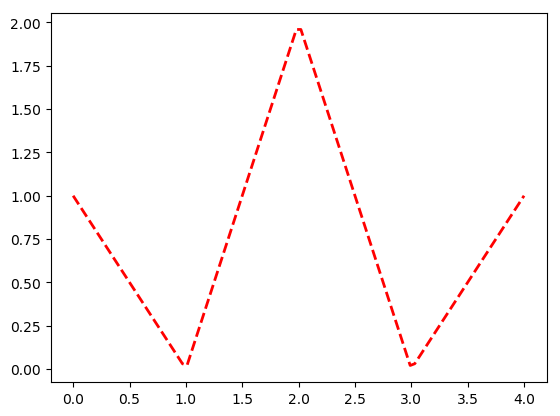

In [5]:
x = linspace(0,4,100); y = gr.(x);
plot(x, y, color="red", linewidth=2.0, linestyle="--");

# Helper functions

In [9]:
function hrepr(model)
    poly = polyhedron(model, CDDLibrary(:exact));
    removehredundancy!(poly)
    polyrep = SimpleHRepresentation(poly); 
    return polyrep
end

hrepr (generic function with 1 method)

In [10]:
function vrepr(model)
    poly = polyhedron(model, CDDLibrary(:exact));
    removevredundancy!(poly)
    ineq = SimpleVRepresentation(poly); 
    return ineq
end

vrepr (generic function with 1 method)

In [30]:
function implied(polyrep, vars)
    for eq in eqs(polyrep)
        println("LHS = ", dot(convert.(Float64,eq.a), vars))
        println("RHS = ", convert.(Float64,eq.β))
    end
end

implied (generic function with 1 method)

# Big M formulation

In [6]:
function bigMform()
    Ml = [maximum(m[i]*d+c[i]-gr.(d)) for i in 1:k];
    Mu = [maximum(gr.(d)-(m[i]*d+c[i])) for i in 1:k];
    model = Model(); 
    @variable(model, x); 
    @variable(model, z);
    @variable(model, y[1:4], Bin);
    @constraint(model, [i=1:k], d[i]-(d[i]-d[1])*(1-y[i]) <=x);
    @constraint(model, [i=1:k], d[i+1]+(d[k+1]-d[i+1])*(1-y[i]) >= x);
    @constraint(model, [i=1:k], m[i]*x+c[i]-Ml[i]*(1-y[i]) <= z);
    @constraint(model, [i=1:k], m[i]*x+c[i]+Mu[i]*(1-y[i]) >= z);
    @constraint(model, sum(y) == 1);
    v = vcat(x,z,y)
    return model, v
end

bigMform (generic function with 1 method)

In [34]:
bMm, bMv = bigMform();

## part a)

In [35]:
vrepr(bMm)

V-representation
begin
 52 7 rational
 1 1//1 0//1 0//1 1//1 0//1 0//1
 1 2//1 2//1 0//1 1//1 0//1 0//1
 1 5//2 1//2 1//2 1//2 0//1 0//1
 1 12//5 9//5 1//5 4//5 0//1 0//1
 1 17//8 -7//8 5//8 3//8 0//1 0//1
 1 2//1 -1//1 3//5 2//5 0//1 0//1
 1 2//1 -1//1 0//1 2//5 0//1 3//5
 1 5//2 -1//2 0//1 3//10 7//10 0//1
 1 2//1 -1//1 0//1 2//5 2//5 1//5
 1 2//1 -1//1 1//5 2//5 2//5 0//1
 1 3//2 -1//2 0//1 7//10 3//10 0//1
 1 3//1 0//1 0//1 0//1 0//1 1//1
 1 2//1 -1//1 1//3 0//1 0//1 2//3
 1 2//1 -1//1 0//1 1//3 0//1 2//3
 1 2//1 -1//1 0//1 0//1 1//3 2//3
 1 2//1 -1//1 0//1 0//1 2//5 3//5
 1 2//1 -1//1 3//5 0//1 2//5 0//1
 1 3//2 1//2 0//1 0//1 1//2 1//2
 1 8//5 9//5 0//1 0//1 4//5 1//5
 1 15//8 -7//8 0//1 0//1 3//8 5//8
 1 1//1 3//2 0//1 1//2 1//2 0//1
 1 6//5 11//5 0//1 2//5 3//5 0//1
 1 8//9 13//9 0//1 4//9 4//9 1//9
 1 9//13 10//13 0//1 7//13 3//13 3//13
 1 9//10 7//10 0//1 7//10 0//1 3//10
 1 15//23 8//23 0//1 15//23 3//23 5//23
 1 3//4 1//4 0//1 3//4 0//1 1//4
 1 5//6 1//6 0//1 5//6 1//6 0//1

## part b)

In [48]:
polyrepbM = hrepr(bMm)
bMsimple = Model(); @variable(bMsimple, x); @variable(bMsimple, z);@variable(bMsimple, y[1:k], Bin);
@constraint(bMsimple,convert.(Int64,polyrepbM.A)*vcat(x,z,y) .<= convert.(Int64,polyrepbM.b));

In [49]:
bMsimple

Feasibility problem with:
 * 17 linear constraints
 * 6 variables: 4 binary
Solver is default solver

In [41]:
implied(polyrepbM, vcat(x,z,y))

LHS = y[1] + y[2] + y[3] + y[4]
RHS = 1.0


## CC formulation

In [42]:
function CCform()
    model = Model(); 
    @variable(model, x); 
    @variable(model, z);
    @variable(model, y[1:k], Bin);
    @variable(model, λ[1:k+1]);
    @constraint(model, dot(λ,d) == x);
    @constraint(model, dot(λ,gr.(d))== z);
    @constraint(model, sum(λ) == 1);
    @constraint(model, λ[1] <= y[1]);
    @constraint(model, [i=2:k], λ[i] <= y[i-1]+y[i]);
    @constraint(model, λ[k+1] <= y[k]);
    @constraint(model, sum(y) == 1);
    @constraint(model, [i=1:k], λ[i] >= 0);
    @constraint(model, [i=1:k], λ[i] <= 1);
    v = vcat(x,z,y,λ)
    return model, v
end

CCform (generic function with 1 method)

In [44]:
CCm, CCv = CCform();

## part a)

In [45]:
vrepr(CCm)

V-representation
begin
 15 12 rational
 1 2//1 2//1 0//1 1//1 0//1 0//1 0//1 0//1 1//1 0//1 0//1
 1 7//2 1//2 0//1 1//2 0//1 1//2 0//1 0//1 0//1 1//2 1//2
 1 7//2 1//2 1//2 0//1 0//1 1//2 0//1 0//1 0//1 1//2 1//2
 1 5//2 1//1 1//2 0//1 1//2 0//1 0//1 0//1 1//2 1//2 0//1
 1 0//1 1//1 1//1 0//1 0//1 0//1 1//1 0//1 0//1 0//1 0//1
 1 1//2 1//2 1//2 0//1 1//2 0//1 1//2 1//2 0//1 0//1 0//1
 1 -3//1 0//1 1//1 0//1 0//1 0//1 1//1 1//1 0//1 0//1 -1//1
 1 -1//1 1//1 0//1 1//1 0//1 0//1 0//1 1//1 1//1 0//1 -1//1
 1 1//1 0//1 1//1 0//1 0//1 0//1 0//1 1//1 0//1 0//1 0//1
 1 1//1 0//1 0//1 1//1 0//1 0//1 0//1 1//1 0//1 0//1 0//1
 1 1//1 1//1 0//1 0//1 1//1 0//1 0//1 0//1 1//1 1//1 -1//1
 1 3//1 0//1 0//1 0//1 0//1 1//1 0//1 0//1 0//1 1//1 0//1
 1 3//1 0//1 0//1 0//1 1//1 0//1 0//1 0//1 0//1 1//1 0//1
 1 2//1 2//1 0//1 0//1 1//1 0//1 0//1 0//1 1//1 0//1 0//1
 1 4//1 1//1 0//1 0//1 0//1 1//1 0//1 0//1 0//1 0//1 1//1
end

## part b)

In [53]:
polyrepCC = hrepr(CCm)
CCsimple = Model(); @variable(CCsimple, x); @variable(CCsimple, z);@variable(CCsimple, y[1:k], Bin); @variable(CCsimple, λ[1:k+1]);
@constraint(CCsimple,convert.(Int64,polyrepCC.A)*vcat(x,z,y, λ) .<= convert.(Int64,polyrepCC.b));

In [54]:
CCsimple

Feasibility problem with:
 * 16 linear constraints
 * 11 variables: 4 binary
Solver is default solver

In [56]:
implied(polyrepCC, vcat(x,z,y, λ))

LHS = -x + λ[2] + 2 λ[3] + 3 λ[4] + 4 λ[5]
RHS = 0.0
LHS = -z + λ[1] + 2 λ[3] + λ[5]
RHS = 0.0
LHS = λ[1] + λ[2] + λ[3] + λ[4] + λ[5]
RHS = 1.0
LHS = y[1] + y[2] + y[3] + y[4]
RHS = 1.0
